In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec

import matplotlib.patheffects as path_effects

import re,glob,os,json
import numpy as np
import pandas as pd

typeface='Helvetica Neue'
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

base_path='/Users/evogytis/Documents/manuscripts/skeeters/data'

from collections import defaultdict, namedtuple
Member = namedtuple('Member', ['contig', 'length', 'percent_id', 'percent_id_sign', 'sample', 'coverage'])

def parse_cdhit_row(row):
    if '*' in row:
        index, length, name, percent_id = row.split()
        percent_id_sign, percent_id = '0', 100
    else:
        index, length, name, _, percent_id = row.split()
    length = int(length.strip(',nt'))
    name = name.strip('>').strip('.')
    sample, contig = name.split('~')
    coverage = float(contig.split('_')[-1])
    
    if percent_id != 100:
        percent_id_sign, percent_id = percent_id.strip('%').split('/')
        percent_id = float(percent_id)
    return Member(contig=contig, sample=sample, length=length,
                  percent_id=percent_id, percent_id_sign=percent_id_sign, coverage=coverage)


clusters = defaultdict(list)
with open(os.path.join(base_path,'500_contigs_cluster.clstr'), 'r') as file:
    for line in file:
        if line.startswith('>Cluster'):
            cluster_id = line.split()[-1]
        else:
            member = parse_cdhit_row(line)
            if 'water' in member.sample.lower():
                continue
            clusters[cluster_id].append(member)
            

contig_info={}

for line in open(os.path.join(base_path,'s3/contig_quality_concat/contig_calls_decontam.tsv'),'r'): ## iterate over lines
    l=line.strip('\n').split('\t')
    if l[0]=='sample':
        header={x:i for i,x in enumerate(l)} ## create header dict
    else:
        sample=l[header['sample']]
        contig_name=l[header['contig_name']] ## get contig name
        read_count=int(float(l[header['read_count']])) ## get read count

#         if sample not in contig_reads:
#             contig_reads[sample]={}
        if sample not in contig_info:
            contig_info[sample]={}
            
        contig_info[sample][contig_name]={x:l[header[x]] for x in header}

total_reads={}
for sample in contig_info:
    total_reads[sample]=0
    for contig in contig_info[sample]:
        blasted=True if contig_info[sample][contig]['blasted']=='True' else False
        curated=True if contig_info[sample][contig]['curated']=='True' else False
        read_count=int(contig_info[sample][contig]['read_count'])
#         print(contig,read_count,blasted,curated)
        total_reads[sample]+=read_count
    
print(sum(total_reads.values()))

in_json=open(os.path.join(base_path,'darkmatter/virus.json'),'r')
virus=json.load(in_json)

segmented_RdRps=[pol for pol in virus if len(virus[pol]['segments'])>0] ## all segmented viruses
# segmented_RdRps=virus.keys()
in_json.close()


metadata={}
for line in open(os.path.join(base_path,'metadata/CMS001_CMS002_MergedAnnotations.csv'),'r'):
    l=line.strip('\r\n').split(',')
    if 'NewIDseqName' in l[0]:
        header=l
    else:
        metadata[l[0]]={header[i]:l[i].strip(' ') for i in range(len(l))} ## load metadata

        
sample_colour={'ALCO':(0.49803923567136127, 0.43267975250879925, 0.52287583549817396), ## purple
               'WVAL':(0.88366013765335083, 0.77908497055371606, 0.18562091886997223), ## yellow
               'COAV':(0.8162552973803352, 0.41062668737243202, 0.29078047883276847), ## red
               'PLCR':(0.28098424626331703, 0.63955403192370541, 0.39507882933990629), ## green
               'SAND':(0.4666666666666667, 0.7450980392156863, 0.8588235294117647), ## light blue
               'NA':  '#C0C0C0'}

13014814


In [8]:
read_matrix={} ## matrix for RPM
length_matrix={} ## matrix for contig lengths

sample_order=[] ## keep track of order in which samples appeared
row_names=[] ## will contain nicely formatted row names

breaks=[] ## store ends of rows
did_not_blast=[] ## keep track of what blasted

species=lambda sample: '%s %s'%(metadata[sample]['ska_genus'],metadata[sample]['ska_species'])
sample_loc=lambda sample: metadata[sample]['collected_by']

order=['RdRp_PB1','RdRp_L','RdRp_RNA1','RdRp_RNA2','RdRp_VP2','RdRp_VP1','PB2','PA','NP','gp64','GP','hypothetical','hypothetical2','hypothetical3']+['RNA%d'%(i) for i in range(12)]+['VP%d'%(i) for i in range(12)]+['Chaq_RNA3']

print(order)
# sort_RdRps=lambda k: (virus[k]['family'],summarise.index(int(k)) if int(k) in summarise else (-len(clusters[k])) ## sorting RdRp clusters by family, then cluster size
# sort_RdRps=lambda k: (virus[k]['family'],-len(clusters[k]))
sort_RdRps=lambda k: (virus[k]['family'],-len(clusters[k]))

sort_segs=lambda k: -order.index(k) if k in order else k

subset_order=[1168,70,1181,1170,1160]
subset_row_names={pol: [] for pol in subset_order}

for p,pol in enumerate(sorted(segmented_RdRps,key=sort_RdRps)):
    family=virus[pol]['family']
    
    name=virus[pol]['provisional_name'] if 'provisional_name' in virus[pol] else virus[pol]['name']
    samples=virus[pol]['samples']
    
    for sample in sorted(samples,key=lambda k: (sample_loc(k),species(k),-total_reads[k])):
        if sample not in sample_order:
            sample_order.append(sample)
    
    for seg in sorted(virus[pol]['segments'],key=sort_segs,reverse=True): ## iterate over segments
        segment_clusters=list(map(str,virus[pol]['segments'][seg]['clusters'])) ## get clusters that contain this segment
        s=seg if 'RdRp' not in seg else seg.split('_')[1]
        
        row_name='%s %s (%s)'%(s,name,family.replace('viridae','')) ## format row name
        row_names.append(row_name) ## remember row name
        if int(pol) in subset_row_names:
            subset_row_names[int(pol)].append(row_name)
        
        if row_name not in read_matrix: ## row not in matrix, adding row with columns
            read_matrix[row_name]={sample: 0 for sample in samples}
            length_matrix[row_name]={sample: 0 for sample in samples}
        
        B=[] ## True/False for whether contig blasted
        for clust in segment_clusters: ## iterate over each cluster
            members=clusters[clust] ## get member contigs
            for m in members:
                if m.contig in contig_info[m.sample]: ## check that contig is not contamination
                    B.append(True if contig_info[m.sample][m.contig]['blasted']=='True' else False) ## check if contig blasted
                    length_matrix[row_name][m.sample]+=m.length ## add contig length
                    read_matrix[row_name][m.sample]+=(int(contig_info[m.sample][m.contig]['read_count']) / total_reads[m.sample]) ## read count fraction of total sample nonhost reads
        if B.count(False)>len(B)/2: ## count how many member contigs blasted
            did_not_blast.append(row_name)
            
rmatrix=pd.DataFrame(read_matrix,index=sample_order) ## turn to pandas dataframe
lmatrix=pd.DataFrame(length_matrix,index=sample_order)

print('RPM minmax:',min(rmatrix.min()),max(rmatrix.max()))

['RdRp_PB1', 'RdRp_L', 'RdRp_RNA1', 'RdRp_RNA2', 'RdRp_VP2', 'RdRp_VP1', 'PB2', 'PA', 'NP', 'gp64', 'GP', 'hypothetical', 'hypothetical2', 'hypothetical3', 'RNA0', 'RNA1', 'RNA2', 'RNA3', 'RNA4', 'RNA5', 'RNA6', 'RNA7', 'RNA8', 'RNA9', 'RNA10', 'RNA11', 'VP0', 'VP1', 'VP2', 'VP3', 'VP4', 'VP5', 'VP6', 'VP7', 'VP8', 'VP9', 'VP10', 'VP11', 'Chaq_RNA3']
RPM minmax: 0.0 0.9438132399385015


genome 1399|Botourmia-like (Botourmia)
genome 1438|Botourmia-like (Botourmia)
genome 1479|Botourmia-like (Botourmia)
genome 3061|Botourmia-like (Botourmia)
genome 4269|Botourmia-like (Botourmia)
genome 9191|Botourmia-like (Botourmia)
RNA1 Hubei chryso-like virus 1 (Chryso)
RNA2 Hubei chryso-like virus 1 (Chryso)
RNA3 Hubei chryso-like virus 1 (Chryso)
RNA4 Hubei chryso-like virus 1 (Chryso)
RNA1 Keturi virus (Chryso)
RNA2 Keturi virus (Chryso)
RNA3 Keturi virus (Chryso)
RNA4 Keturi virus (Chryso)
L Culex mosquito virus 4 (Chu)
RNA2 Culex mosquito virus 4 (Chu)
genome Wuhan insect virus 33 (Dicistro)
genome Placeda virus (Flavi)
genome Culex flavivirus (Flavi)
genome Calbertado virus (Flavi)
genome 25|Ifla-like (Ifla)
genome Culex iflavi-like virus 4 (Ifla)
genome 24|Ifla-like (Ifla)
genome Culex iflavi-like virus 3 (Ifla)
genome Chimba virus (Levi)
genome 416|Levi-like (Levi)
RNA1 Culex-associated Luteo-like virus (Luteo)
RNA2 Culex-associated Luteo-like virus (Luteo)
genome 98|Luteo-l

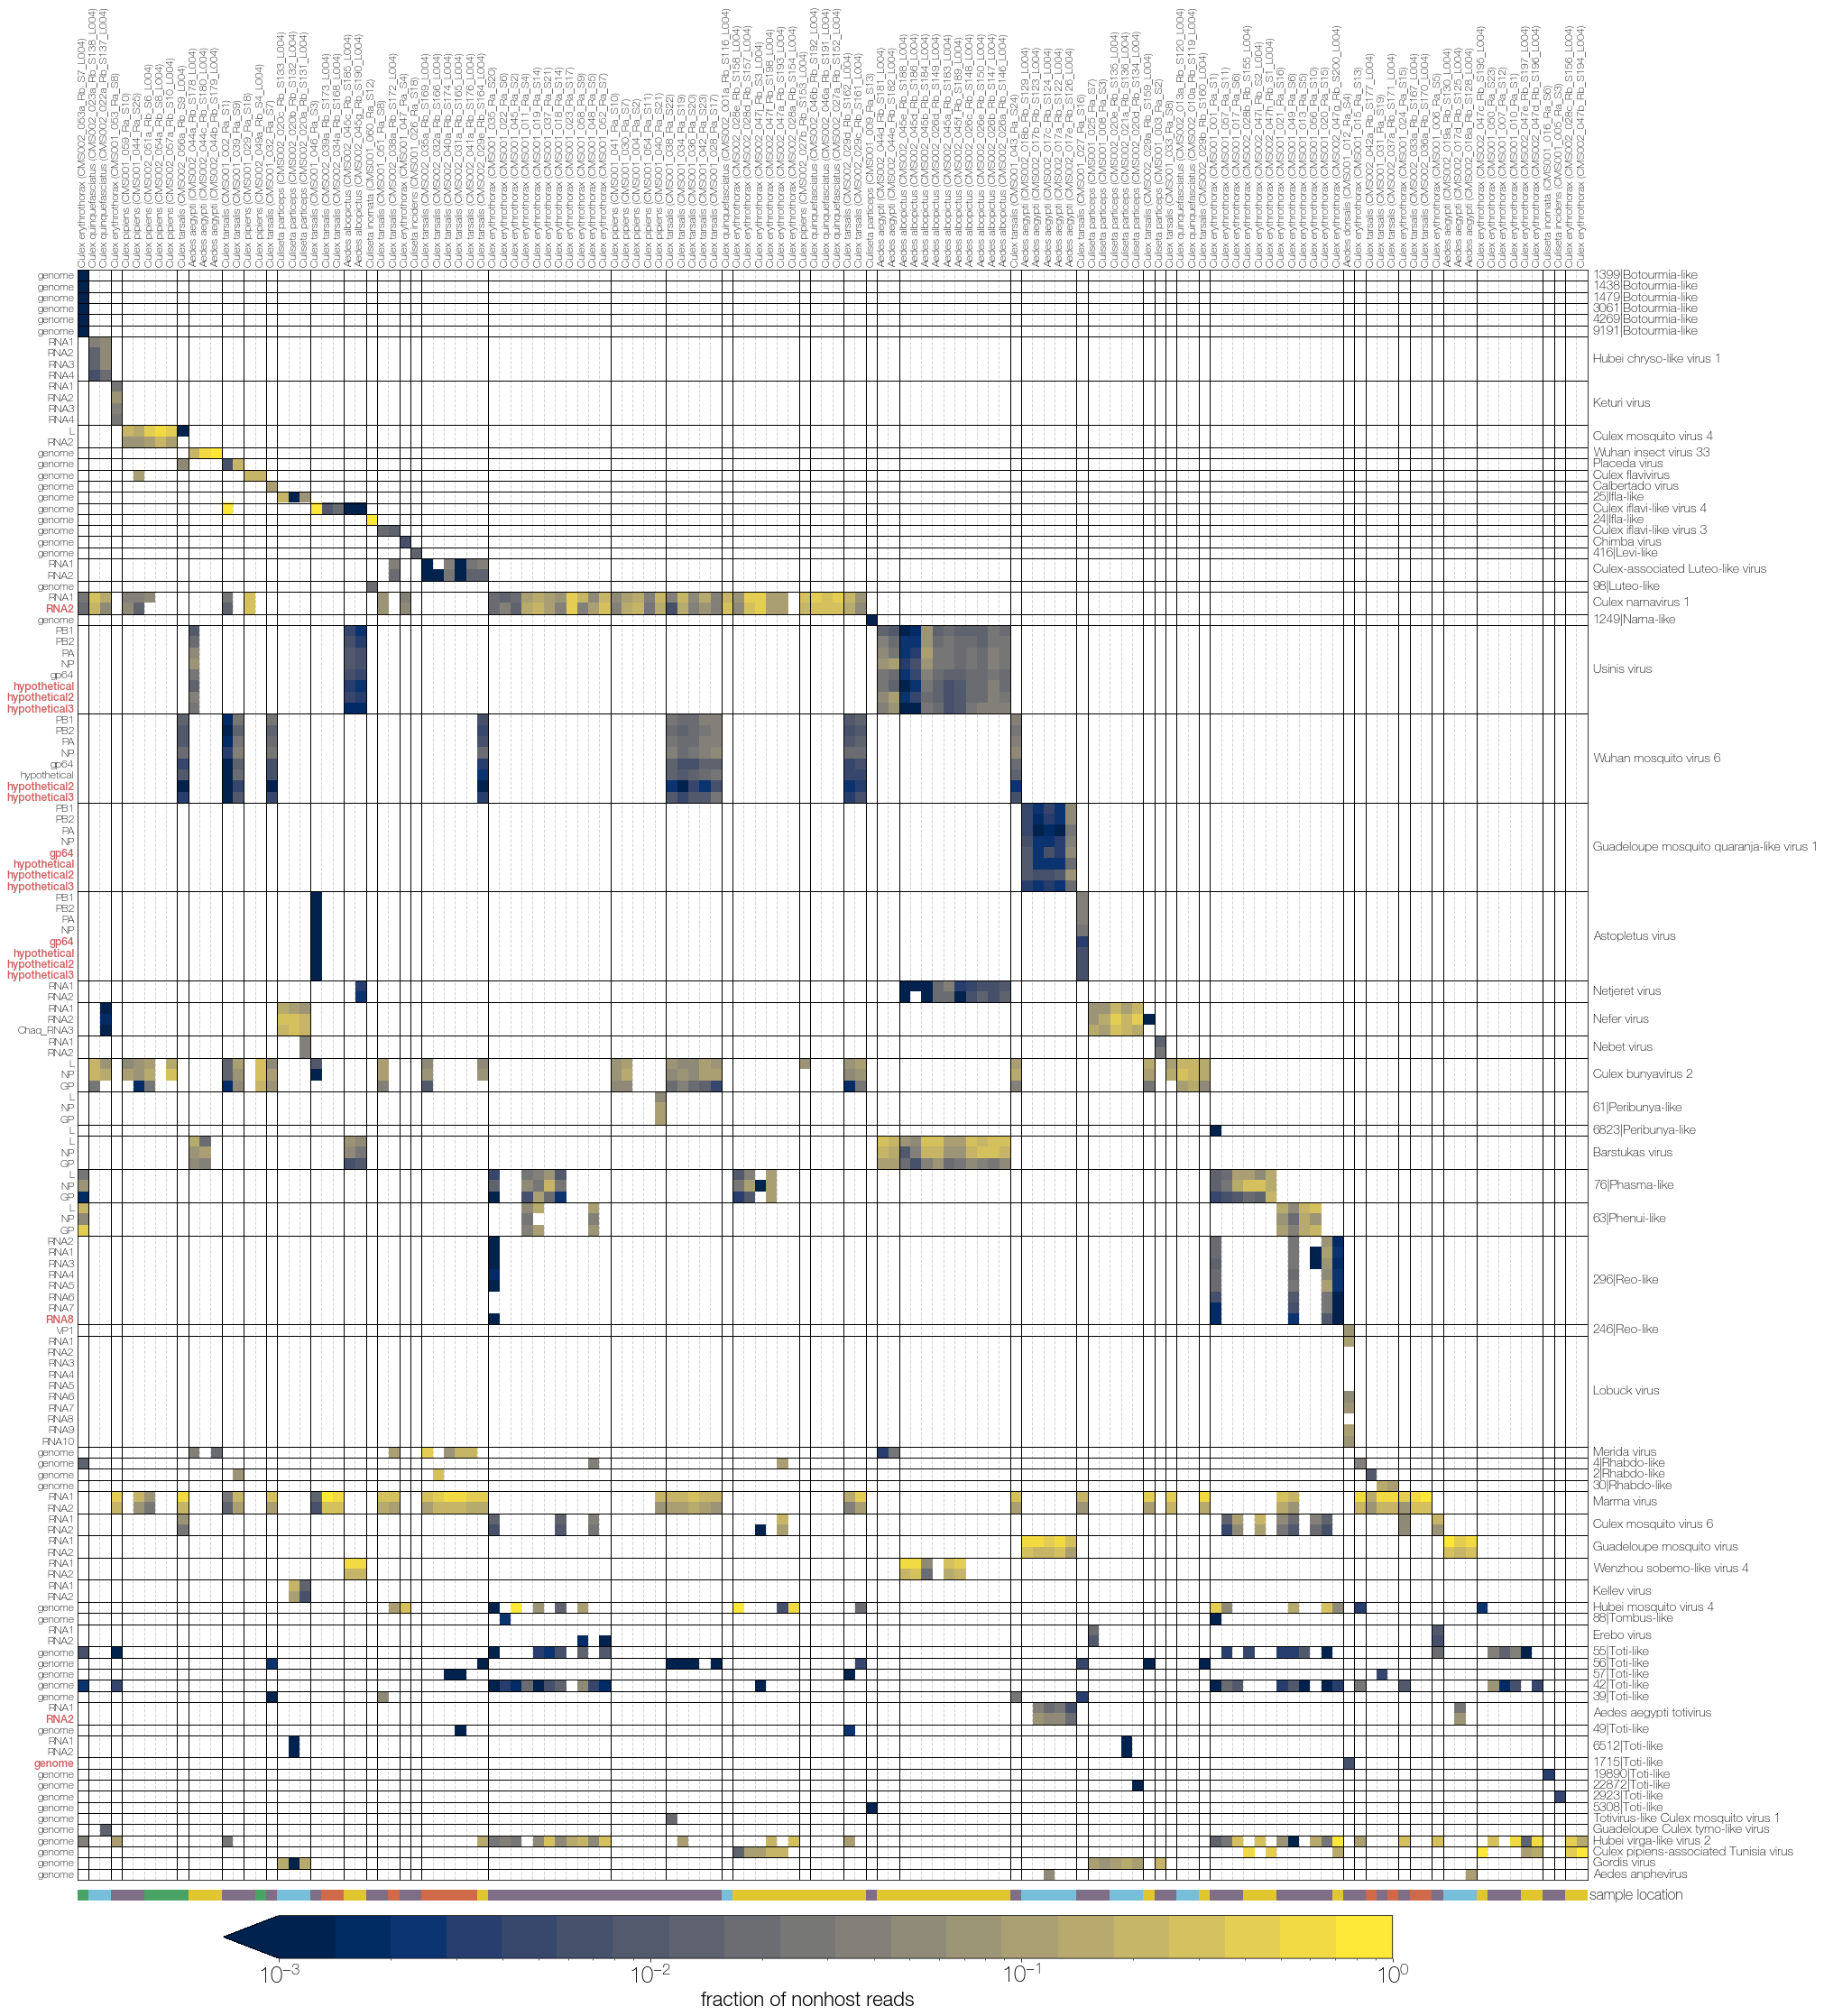

In [9]:
import textwrap

# subsetting=False ## showing all clusters
subsetting=False ## showing a subset of clusters (4 Orthomyxos + 1 Bunya)

# showing='length'
showing='reads'

if showing=='reads':
    matrix=rmatrix
    norm=mpl.colors.LogNorm(vmin=0.001,vmax=1.0)
    extend='min'
elif showing=='length':
    matrix=lmatrix
    norm=mpl.colors.Normalize(vmin=500,vmax=2500)
    extend='both'

if subsetting==True:
    rows=sum(subset_row_names.values(),[])
    subset_species_order={'Aedes albopictus': 0, 
                          'Aedes aegypti': 1, 
                          'Culex tarsalis': 2}

    matrix=matrix[rows].reindex(sorted(sample_order,key=lambda k: (subset_species_order[species(k)] if species(k) in subset_species_order else np.inf,sample_loc(k)!='WVAL'))).dropna(how='all') ## reindex only to Orthomyxos+Bunya, sort by species and location (in a way that gives good clusters), drop rows/columns that are all NaN
# else:
    matrix=matrix.reindex(sorted(matrix.index,key=species))
    
if subsetting:
    base=20
else:
    base=30
    
fig = plt.figure(figsize=(base, 1+base*(matrix.shape[1]/matrix.shape[0])),facecolor='w') 
gs = gridspec.GridSpec(1,1,wspace=0.05,hspace=0.0)

ax=plt.subplot(gs[0],facecolor='w') ## new subplot

def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki, key in enumerate(('red','green','blue')):
        cdict[key] = [(indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in range(N+1)]
    # Return colormap object.
    return mpl.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

cmap=cmap_discretize(mpl.cm.cividis,20)
ax.matshow(matrix.T,cmap=cmap,norm=norm,zorder=1)

ax.set_xticks(range(len(matrix.index)))
ax.set_yticks(range(len(matrix.columns)))

ax.set_xticklabels(matrix.index,rotation=90,size=12)
ax.set_yticklabels(matrix.columns,size=14)

for ticklabel in ax.get_yticklabels():
    print(ticklabel.get_text())
    if ticklabel.get_text() in did_not_blast:
        ticklabel.set_color('indianred')
        ticklabel.set_fontweight(500)
    else:
        pass

if subsetting==False:
    for t,ticklabel in enumerate(ax.get_xticklabels()):
        loc=sample_loc(ticklabel.get_text())
        if loc in sample_colour:
            colour=sample_colour[loc]
        else:
            colour='grey'
        
        ax.add_patch(plt.Rectangle((t-0.5,len(row_names)+0.4),1,1,
                                   facecolor=colour,edgecolor='none',zorder=100,clip_on=False))
        
                
        if t==len(ax.get_xticklabels())-1:
            ax.text(t+0.7,len(row_names)+0.9,'sample location',ha='left',va='center',size=16,clip_on=False)

modify_name=lambda k: ' '.join(k.get_text().split(' ')[1:-1])
virus_names=[modify_name(t) for t in ax.get_yticklabels()]
virus_coords={v: [i for i in range(len(virus_names)) if virus_names[i]==v] for v in set(virus_names)}

lw=2 if subsetting else 1
textsize=28 if subsetting else 14
for v in virus_coords:
    w=v
    if len(v)>10 and len(matrix)<50:
        w='\n'.join(textwrap.wrap(v,12))
    ax.text(len(matrix.index),np.mean(virus_coords[v]),w,size=textsize,rotation=0,va='center',ha='left')
    ax.axhline(max(virus_coords[v])+0.5,lw=lw,color='k') ## add horizontal line
    

counter=0
for s in range(len(matrix.index)):
    if s==len(matrix.index)-1:
        if subsetting==True:
            ax.text(s-counter/2+0.5,-0.8,species(matrix.index[s]),size=28,rotation=0,va='bottom',ha='center')
            
    elif species(matrix.index[s])!=species(matrix.index[s+1]):
        if subsetting==True:
            ax.text(s-counter/2+0.5,-0.8,species(matrix.index[s]),size=28,rotation=0,va='bottom',ha='center')
        ax.axvline(s+0.5,lw=lw,color='k') ## add vertical line when species changes
        counter=0
    
    counter+=1        

if subsetting:
    ax.set_xticklabels([])
    ax.set_yticklabels([label.get_text().split(' ')[0] for label in ax.get_yticklabels()],size=20)
else:
    ax.set_yticklabels([label.get_text().split(' ')[0] for label in ax.get_yticklabels()],size=12)
    ax.set_xticklabels(['%s (%s)'%(species(s),s) for s in sample_order])
    
ax.tick_params(size=0)

ax.vlines(np.arange(-0.5,len(matrix.index)-0.5,1.0),-0.5,len(matrix.columns)-0.5,color='lightgrey',lw=1,ls='--',zorder=0)

ax.xaxis.set_label_position('bottom')
ax.yaxis.set_label_position('right')

ax.set_xlim(-0.5,len(matrix.index)-0.5)
ax.set_ylim(len(matrix.columns)-0.5,-0.5)

axcb = fig.add_axes([0.2, 0.09, 0.6, 0.02], frame_on=False)
cb = mpl.colorbar.ColorbarBase(axcb,cmap=cmap,norm=norm,orientation='horizontal',extend=extend,alpha=1.0,drawedges=False)

axcb.tick_params(labelsize=24)
axcb.yaxis.set_label_position('right')
axcb.yaxis.tick_left()

if showing=='reads':
    axcb.set_xlabel('fraction of nonhost reads',size=22)
elif showing=='length':
    axcb.set_xlabel('contig length',labelpad=8,size=22)

# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/figSX_co-occurrence_%s.png'%(showing),dpi=300,bbox_inches='tight')
# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/figSX_co-occurrence_%s.pdf'%(showing),dpi=300,bbox_inches='tight')
    
out=open('/Users/evogytis/Downloads/TableSX_cooccurrenceReadFractions.tsv','w')
matrix.to_csv(out,sep='\t')
out.close()

plt.show()

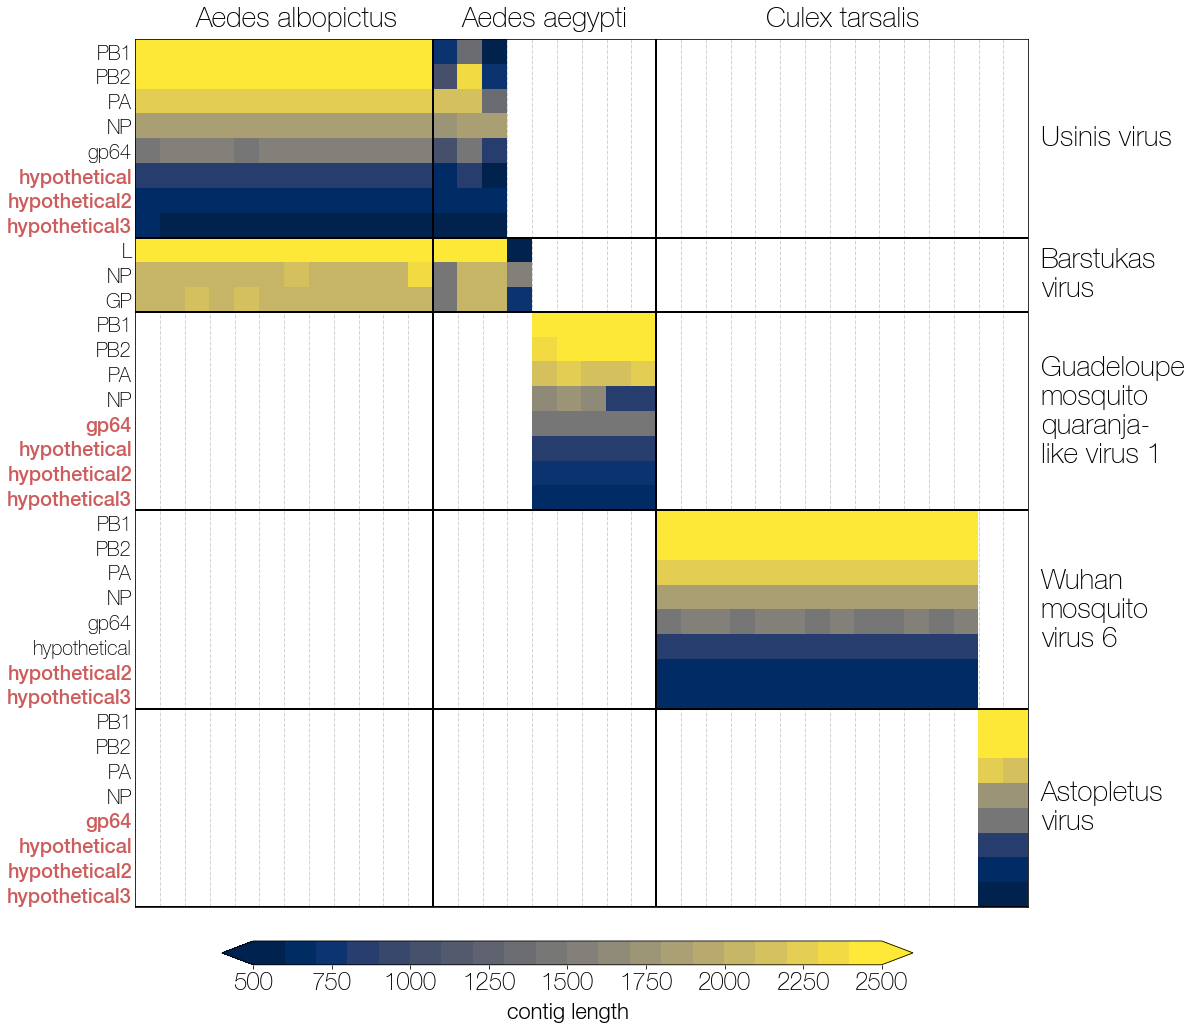

In [18]:
import textwrap

# subsetting=False ## showing all clusters
subsetting=True ## showing a subset of clusters (4 Orthomyxos + 1 Bunya)

showing='length'
# showing='reads'

sample_order=[]
for so in subset_order:
    for sa in virus[str(so)]['samples']:
        if sa not in sample_order:
            sample_order.append(sa)

if showing=='reads':
    matrix=rmatrix
#     norm=mpl.colors.LogNorm(vmin=1,vmax=1500000)
    norm=mpl.colors.LogNorm(vmin=1000,vmax=7000000)
    extend='max'
elif showing=='length':
    matrix=lmatrix
    norm=mpl.colors.Normalize(vmin=500,vmax=2500)
    extend='both'

if subsetting==True:
    rows=sum(subset_row_names.values(),[])
    subset_species_order={'Aedes albopictus': 0, 
                          'Aedes aegypti': 1, 
                          'Culex tarsalis': 2}

    matrix=matrix[rows].reindex(sorted(sample_order,key=lambda k: (subset_species_order[species(k)] if species(k) in subset_species_order else np.inf,sample_loc(k)!='WVAL'))).dropna(how='all') ## reindex only to Orthomyxos+Bunya, sort by species and location (in a way that gives good clusters), drop rows/columns that are all NaN
# else:
#     matrix=matrix.reindex(sorted(matrix.index,key=species))
    
if subsetting:
    base=16
else:
    base=25
    
fig = plt.figure(figsize=(base, 1+base*(matrix.shape[1]/matrix.shape[0])),facecolor='w') 
gs = gridspec.GridSpec(1,1,wspace=0.05,hspace=0.0)

ax=plt.subplot(gs[0],facecolor='w') ## new subplot

def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki, key in enumerate(('red','green','blue')):
        cdict[key] = [(indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in range(N+1)]
    # Return colormap object.
    return mpl.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

cmap=cmap_discretize(mpl.cm.cividis,20)
ax.matshow(matrix.T,cmap=cmap,norm=norm,zorder=1)

ax.set_xticks(range(len(matrix.index)))
ax.set_yticks(range(len(matrix.columns)))

ax.set_xticklabels(matrix.index,rotation=90,size=12)
ax.set_yticklabels(matrix.columns,size=14)

for ticklabel in ax.get_yticklabels():
    if ticklabel.get_text() in did_not_blast:
        ticklabel.set_color('indianred')
        ticklabel.set_fontweight(500)
    else:
        pass

if subsetting==False:
    for t,ticklabel in enumerate(ax.get_xticklabels()):
        loc=sample_loc(ticklabel.get_text())
        if loc in sample_colour:
            colour=sample_colour[loc]
        else:
            colour='grey'
        
        ax.add_patch(plt.Rectangle((t-0.5,len(row_names)+0.4),1,1,
                                   facecolor=colour,edgecolor='none',zorder=100,clip_on=False))

modify_name=lambda k: ' '.join(k.get_text().split(' ')[1:-1])
virus_names=[modify_name(t) for t in ax.get_yticklabels()]
virus_coords={v: [i for i in range(len(virus_names)) if virus_names[i]==v] for v in set(virus_names)}

lw=2 if subsetting else 1
textsize=28 if subsetting else 14
for v in virus_coords:
    w=v
    if len(v)>10 and len(matrix)<50:
        w='\n'.join(textwrap.wrap(v,12))
    ax.text(len(matrix.index),np.mean(virus_coords[v]),w,size=textsize,rotation=0,va='center',ha='left')
    ax.axhline(max(virus_coords[v])+0.5,lw=lw,color='k') 
    

counter=0
for s in range(len(matrix.index)):
    if s==len(matrix.index)-1:
        if subsetting==True:
            ax.text(s-counter/2+0.5,-0.8,species(matrix.index[s]),size=28,rotation=0,va='bottom',ha='center')
            
    elif species(matrix.index[s])!=species(matrix.index[s+1]):
        if subsetting==True:
            ax.text(s-counter/2+0.5,-0.8,species(matrix.index[s]),size=28,rotation=0,va='bottom',ha='center')
        ax.axvline(s+0.5,lw=lw,color='k')
        counter=0
    
    counter+=1        

if subsetting:
    ax.set_xticklabels([])
    ax.set_yticklabels([label.get_text().split(' ')[0] for label in ax.get_yticklabels()],size=20)
else:
    ax.set_yticklabels([label.get_text().split(' ')[0] for label in ax.get_yticklabels()],size=12)
    ax.set_xticklabels(['%s (%s)'%(species(s),s) for s in sample_order])
    
ax.tick_params(size=0)

ax.vlines(np.arange(-0.5,len(matrix.index)-0.5,1.0),-0.5,len(matrix.columns)-0.5,color='lightgrey',lw=1,ls='--',zorder=0)

ax.xaxis.set_label_position('bottom')
ax.yaxis.set_label_position('right')

ax.set_xlim(-0.5,len(matrix.index)-0.5)
ax.set_ylim(len(matrix.columns)-0.5,-0.5)

axcb = fig.add_axes([0.2, 0.09, 0.6, 0.02], frame_on=False)
cb = mpl.colorbar.ColorbarBase(axcb,cmap=cmap,norm=norm,orientation='horizontal',extend=extend,alpha=1.0,drawedges=False)

axcb.tick_params(labelsize=24)
axcb.yaxis.set_label_position('right')
axcb.yaxis.tick_left()

if showing=='reads':
    axcb.set_xlabel('RPM',size=22)
elif showing=='length':
    axcb.set_xlabel('contig length',labelpad=8,size=22)

# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig5_co-occurrence_%s.png'%(showing),dpi=300,bbox_inches='tight')
# plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig5_co-occurrence_%s.pdf'%(showing),dpi=300,bbox_inches='tight')

out=open('/Users/evogytis/Downloads/TableSX_orthomyxo-cooccurrence.tsv','w')
matrix.to_csv(out,sep='\t',float_format='%.f')
out.close()
plt.show()
